# <u> Analyzing Purchasing Intention of website visitors </u>

## <u> Problem Statement </u>

This notebook walks through the analysis of a very intriguing dataset from the **UCI Machine Learning Repository**  available due to the hard work of:


Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

The data in question refers to over 12,000 browsing sessions for an e-commerce website, spread out over the course of **one year**. In each instance of the data, there are some neat features available (regarding web-page counts, exit rates, proximity to **"special days"** among many others). All the key features are analyzed below in the Exploratory Data Analysis section, in order to get a sense of how each feature impacts our main question: Will the customer end his/her browsing session with a transaction?

The prime focus of the earlier sections is to carry out some Exploratory Data Analysis on the dataset. After that, a **Naive Bayes Classifier** is used in an attempt to classify customers into two categories as mentioned above.

After inspecting a disappointing accuracy result, a finer subset of features are filtered out via **Principal Component Analysis** and used to **rebuild** the Bayesian classifier to obtain a much better result, followed by implementation of an **Artificial Neural Network**.

# <u>Contents:</u>

## <a href="#sec 1"> Section 1: Exploratory Data Analysis </a>
 <ol type="a">
  <li><a href="#1.1">Understanding the problem</a></li>
  <li><a href="#1.2">Importing the data and the tools</a></li>
  <li><a href="#1.3">Page Class Analysis</a></li>
  <li><a href="#1.4">Monthly trends and "Special days"</a></li>
  <li><a href="#1.5">Regional Impact & Customer types</a></li>
  <li><a href="#1.6">Operating System? That's interesting...</a></li>
  
</ol>


## <a href="#sec 2"> Section 2: Data Preprocessing + Vanilla model</a>
 <ol type="a">
  <li><a href="#2.1">Dealing with Categorical Features</a></li>
  <li><a href="#2.2">Preparing the Matrices</a></li>
  <li><a href="#2.3">Scaling/Standardization</a></li>
  <li><a href="#2.4">A very Naive classifier(pun intended) </a></li>
</ol>


## <a href="#sec 3"> Section 3: Dimensionality Reduction and better models </a>
 <ol type="a">
  <li><a href="#3.1">Principal Component Analysis</a></li>
  <li><a href="#3.2">Naive Bayes revisited</a></li>
  <li><a href="#3.3">Building an Artificial Neural Network</a></li> 
</ol>

## <a href="#sec 4"> Section 4: Conclusion </a>
 <ol type="a">
  <li><a href="#4.1">Evaluating results</a></li>
  <li><a href="#4.2">Future improvements</a></li>
  
</ol>

# <div id="sec 1">Section 1: Exploratory Data Analysis</div>

## <div id="1.1">1.1: Understanding the problem</div>

As described above, the dataset contains information regarding the webpage browsing behaviour of customers, from **12,330** sessions. As mentioned in the abstract from the UCI page, we know that each observation is **unique** to a particular user session in order to avoid skewing data for one particular case.

My goal in this project was to study some useful trends in the given features in order to get an idea for which features could be crucial in the classification of users before implementing two **Supervised Models** in order to see if we can predict whether a given user will end up purchasing something at the end of their browsing session or not.

Let's get started on our analysis! 

## <div id="1.2">1.2: Importing the data and the tools</div>

We will make use of the standard Data analysis and numerical computation libraries to carry out this project.

In [341]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats 
from numpy import nan

import math
import matplotlib.mlab as mlab

import warnings
warnings.filterwarnings('ignore')

Let's go ahead and read in the information.

In [342]:
df = pd.read_csv('online_shoppers_intention.csv')

It's always nice to start off by getting a feel of the data in terms of it's dimensions and feature types. So let's perform some routine checks.

In [343]:
df.shape

(12330, 18)

As mentioned in the source website, we know there are 12,330 sessions that we have data available for.
So what does each user's information look like?

In [344]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


There's **17 features** available for each observation, since the last column(**Revenue**) is what we're trying to predict.

Let's check out all of our available features and quickly familiarize ourselves with their interpretations. But first, let's check if we have any missing data.
<div id="to_1.2"></div>

In [345]:
df.isnull().any().any()

False

Phew! That will save us a hefty amount of work in the sense that we won't have to worry about imputing missing information over the remainder of this analysis.

In [346]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

So, essentially we are looking at some very interesting variables:
<ul style="list-style-type:disc;">
  <li> <i>Administrative, Informational, ProductRelated</i> - refer to the **number of webpages** of the **respective** type that the user visited in a given session</li>
  
 
  <li>On that note- <i>'Administrative_Duration', 'Informational_Duration' and 'ProductRelated_Duration'</i> refer to the **time spent** on such pages </li>
  
  <li><i>ExitRates, PageValues and BounceRates</i> refer to some standard metrics obtained via **Google Analytics** for each webpage in the e-commerce site</li>
  
    <li> <i>Month</i> is quite self-explanatory(it refers to month of the observed browsing session), whereas <i>**Special Day**</i> is quite a neat spec. According to the source, it refers to a proximity factor describing **how close** a given observation was to a special day of some sort(eg.Mother's Day, Valentine's Day)</li>
    
      <li>Some other intriguing factors are <i>'OperatingSystems', 'Region' and 'VisitorType'</i>. </li>
</ul>

In the **Exploratory Data Analysis** section, we will take a look at how each of the features mentioned above relate with our Dependent variable(**Revenue**) which has a binary outcome: **True/False**.

**True** means that the given observation involed a customer purchasing something at the end of the session, whereas **False** means the opposite.



In [347]:
df.groupby('Revenue')['VisitorType'].count()

Revenue
False    10422
True      1908
Name: VisitorType, dtype: int64

As we can see, 10,422 visitors left without actually completing a transaction. On the other hand, 1908 instances of successful purchases were recorded. Let's dive into the features then.

## <div id="1.3">1.3: Page Class Analysis</div>

As we can guess, the time spent on a particular type of page will undoubtedly have a good impact on the outcome variable. If we take a moment to think about it, it is highly(to put it lightly) likely that customers who spent time on **Product-related** pages ended up purchasing something. The same thing cannot be necessarily said directly for the other two types of pages. 

Then again, without jumping to drastic unjustified conclusions, let's simply check out the variation in the **total number of pages** for each class over the course of the year for which we have data, with respect to the outcome variable.

Using some basic pandas, let's obtain the necessary information from our DataFrame.

In [348]:
d_1 =  df.groupby('Revenue')[['Administrative', 'Informational',
                    'ProductRelated']].sum().reset_index()
d_1.set_index('Revenue',inplace=True)
d_1

,Administrative,Informational,ProductRelated
Revenue,,,
False,22071,4709,299264
True,6475,1500,91985


It would also be handy to obtain the **Transpose** of this subset, for visualization purposes.

In [349]:
d_2 =pd.DataFrame(d_1.values.T,columns=['False','True'])
d_2.rename(index={0: 'Administrative', 1: 'Informational', 2: 'ProductRelated'},inplace=True)
d_2.rename(columns={'False': 'No_Purchase', 
                    'True': 'Purchase'},inplace=True)
d_2

,No_Purchase,Purchase
Administrative,22071,6475
Informational,4709,1500
ProductRelated,299264,91985


Utilizing **pandas** once more (as we will, throughout this entire notebook), let's take a look at our data.

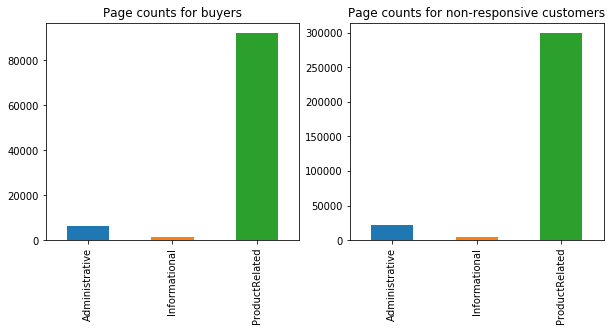

In [350]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,4))
ax1.set_title('Page counts for buyers')
ax2.set_title('Page counts for non-responsive customers')
d_2.Purchase.plot.bar(ax=ax1)
d_2.No_Purchase.plot.bar(ax=ax2)
plt.show()

There is some overlap as expected in the behaviour with respect to each page class(people clearly spent significantly more time on interesting product pages), however there is a huge difference in the total page views between the two outcome classes.

Almost **300,000** visits to product pages resulted in yet no transaction by the end of the browsing session. In comparison to the **91,985** pages that yielded successful outcomes, this highlights a possible point of concern.

Other factors being held constant, perhaps the pages were not successful in engaging the visitors to the extent that they felt compelled to buy an item? Then again, we cannot ignore the fact that this high count could be due to **casual window-shoppers** who had litle to no intention of buying anything in the first place and ended up surfing through several pages without really any end-goal. Once again, a key thing to remember is that our data is heavily weighed down by the **negative outcome class**.

With that in mind, let's check out some pie charts which summarize the outcome feature for each page type:

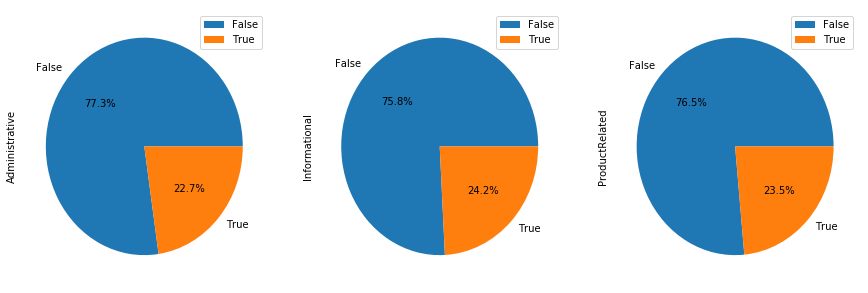

In [351]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,5))

d_1.plot.pie(y='Administrative',autopct='%.1f%%',ax=ax1)
d_1.plot.pie(y='Informational',autopct='%.1f%%',ax=ax2)
d_1.plot.pie(y='ProductRelated',autopct='%.1f%%',ax=ax3)

plt.show()

Interestingly enough, there is a fair amount of symmetry in the distributions.

Now, let's take a look at the **Time Spent** on each different page type.

In [352]:
df[['Administrative_Duration','Informational_Duration',
                     'ProductRelated_Duration']].describe()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration
count,12330.000000,12330.000000,12330.000000
mean,80.818611,34.472398,1194.746220
std,176.779107,140.749294,1913.669288
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,184.137500
50%,7.500000,0.000000,598.936905
75%,93.256250,0.000000,1464.157213
max,3398.750000,2549.375000,63973.522230


Let's break this down:(Note that all the values are measured in seconds)

As we can see, the amount of time spent on **Product pages** is staggeringly higher than that for the other two classes. The median time spent on such pages is almost **80 times** higher than that for Administrative pages. Understandable, as we hardly enjoy staring at the Terms of Services or other such formal information when we're looking at an online catalogue.

Obviously, there are instances where a user possibly **bounced**(left the site without triggering any further requests to the server) and other such cases, resulting in the **minimum** value of 0 for all three classes. There are clearly some high values for the maximum time spent. Maybe some customers were **really engaged** in the content on display, or others simply left their browser running and went off elsewhere. 

But one thing we can notice quite clearly is the fact that the time spent on **Product Related** pages is much more significant. So let's focus more on the numbers there.

Let's visualize the time spent on each page type over the course of the year.

In [353]:
time_df= df.groupby('Revenue')[['Administrative_Duration','Informational_Duration',
                     'ProductRelated_Duration']].sum()

time_df = time_df//3600   # To get time-spent in hours

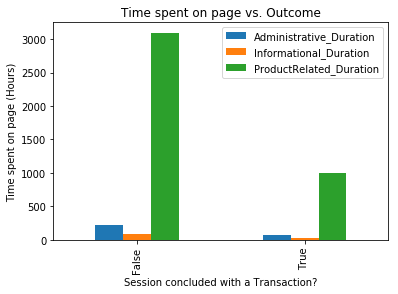

In [354]:
time_df.plot.bar()
plt.xlabel('Session concluded with a Transaction?')
plt.ylabel('Time spent on page (Hours)')
plt.title('Time spent on page vs. Outcome')
plt.show()

If we try analyzing the **Boxplots** for the <i>**Time spent on page**</i> feature, we will end up with a pretty disturbing image.

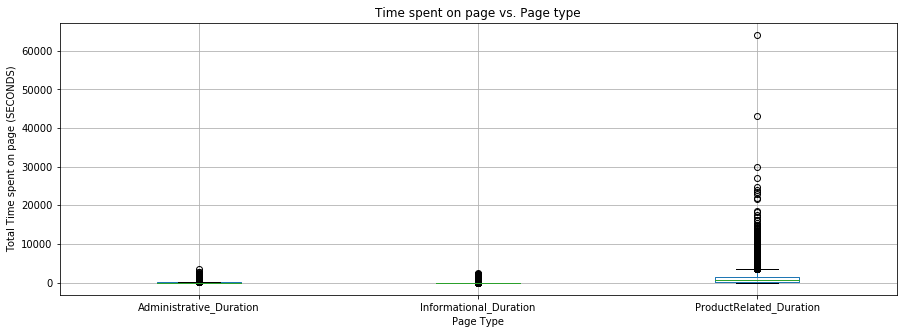

In [355]:
df.boxplot(column=['Administrative_Duration','Informational_Duration',
                     'ProductRelated_Duration'],figsize=(15,5))
plt.xlabel('Page Type')
plt.ylabel('Total Time spent on page (SECONDS)')
plt.title('Time spent on page vs. Page type')
plt.show()

Recalling the basic interpretation of those **nasty dots** on a Boxplot that we can see, we may be freaking out at the absurd amount of outliers present for the **Product Related page duration**.

To get a better idea of the true story that our data is trying to tell us, let's rather focus our efforts to visualize the distribution on the **80th percentile** of the data (with respect to the **ProductRelated_Duration** feature). In doing so, we will be looking at a finer subset of the data, without all the outliers.

In [356]:
df_sub = df[df['ProductRelated_Duration'] <np.percentile(df.ProductRelated_Duration,80)]
df_sub['ProductRelated_Duration'] = df_sub[['ProductRelated_Duration']]/60   #MINUTES

Note that we are considering the **time spent in minutes** in this scenario.

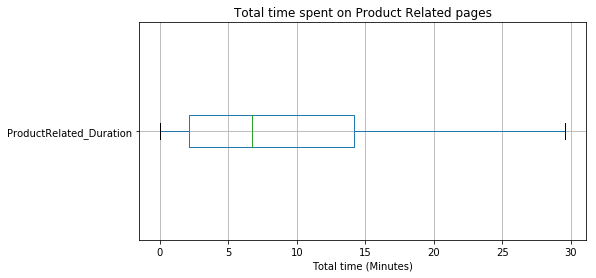

In [357]:
df_sub.boxplot(column='ProductRelated_Duration',figsize=(8,4),vert=False)
plt.xlabel('Total time (Minutes)')
plt.title('Total time spent on Product Related pages')
plt.show()

Thus over the course of the year, the average time(**median**) spent on pages with information about services/commodities came out to be around **7 minutes**, whereas (considering only the 80th percentile of course) the maximum amount of time spent was close to **half an hour**.

Most sessions involved anywhere between **3 minutes and 14 minutes** on Product related pages.

Perhaps some customers had a very particular object in mind when they visited the website and wasted little time in completing their transactions, but others probably took their time before coming to a decision about whether to buy something or not. In any case, there were plenty of non-responsive visitors to the website as well, over the course of the year, but as we can see from our **Bar plot** up there, they do account for a big chunk of the time spent on Product-associated pages.

Let's move onto a different set of features(not related to page types):
changes in behaviour with respect to **time**.

Sounds interesting? Let's dive right in.

## <div id="1.4">1.4: Monthly trends and "Special days"</div>

### Monthly data visualizations

Our dataset contains records over the course of a one year period. One interesting question jumps to mind: which month contains the highest number of successful browsing sessions(ie. ending with a purchase of some sort)?

In [358]:
df_monthly_transacs = df.groupby(['Month','Revenue'])['Administrative'].count().reset_index()
df_monthly_transacs=df_monthly_transacs[df_monthly_transacs['Revenue']==True]
df_monthly_transacs.set_index('Month',inplace=True)
df_monthly_transacs.rename(columns={'Administrative':'Count'},inplace=True)

In [359]:
df_monthly_transacs

,Revenue,Count
Month,,
Aug,True,76
Dec,True,216
Feb,True,3
Jul,True,66
June,True,29
Mar,True,192
May,True,365
Nov,True,760
Oct,True,115


Let's make a quick barplot to see what actually happened.

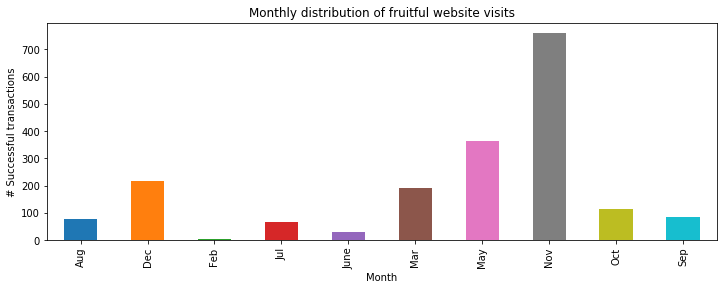

In [360]:
df_monthly_transacs.Count.plot.bar(figsize=(12,4))
plt.xlabel('Month')
plt.ylabel('# Successful transactions')
plt.title('Monthly distribution of fruitful website visits')
plt.show()

One odd feature is that we don't see any data for **January or April**.

But there's still a lot going on there. But the obvious winner there is **November**. With a staggering **700+** successful website visits, it comes out ahead of **May and December**. Perhaps, next year the website could utilize this further by advertising plenty of products and services close to the month of November? 

In any case, it seems rather odd that **February** only boasts three successful website visits, given that it contains **Valentine's Day** and one might expect that several transactions could have been made by people buying gifts during that period. Perhaps the company can come back stronger next time and offer more intriguing products during that time period in order to improve on their figures during that month (note:June, August and September are also rather weak in numbers).

Again, it might be handy to to take a look at the variation in **time spent(in hours) on Product pages** over the months.

In [361]:
monthly_dur =df.groupby(['Month','Revenue'])[['ProductRelated_Duration']].sum().reset_index()
monthly_dur = monthly_dur[monthly_dur['Revenue']==True]    #Only successful visits
monthly_dur['ProductRelated_Duration']=monthly_dur[['ProductRelated_Duration']]//3600   #Time in hours
monthly_dur.drop('Revenue',axis=1,inplace=True)
monthly_dur.set_index('Month',inplace=True)
monthly_dur

,ProductRelated_Duration
Month,
Aug,27.0
Dec,81.0
Feb,0.0
Jul,24.0
June,9.0
Mar,79.0
May,129.0
Nov,581.0
Oct,37.0


Let's visualize this data.

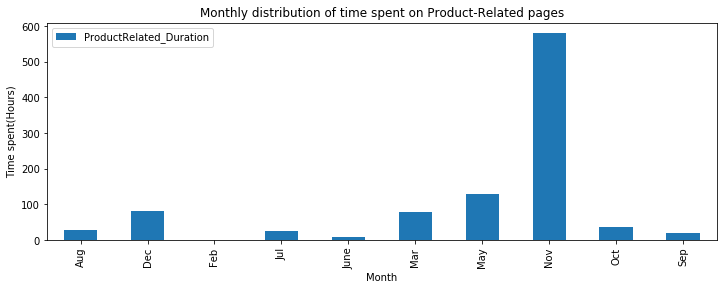

In [362]:
monthly_dur.plot.bar(figsize=(12,4))
plt.xlabel('Month')
plt.ylabel('Time spent(Hours)')
plt.title('Monthly distribution of time spent on Product-Related pages')
plt.show()

It's worth noting that the data is once again dominated by records from November. In any case, a total of **581 hours** were spent browsing products over the course of the month, but February had no time spent at all. This falls in line with our very low value of successful transactions from the monthly distribution Bar plot. However, once again, this seems to be a rather concerning point. Either the data itself is rather distorted or the company simply had a terrible performance during that month.

### The "Special Day" factor

This feature indicates how close a given browsing observation is to a day like Mother's Day, Father's Day,etc. As we can guess, people usually tend to browse for gifts for their friends and family members during such occasions. As stated in the **UCI Data secription**, the special-day proximity factor is calculated with several e-commerce factors in mind(eg. duration between the order date and delivery date).

A simple outline for the value of this factor for Valentine's Day is as follows:

<ul>
  <li>a nonzero value between February 2 and February 12</li>
  <li>zero before and after this date unless it is close to another special day</li>
  <li>maximum value of 1 on February 8</li>
</ul>

Let's check out what this interesting explanatory variable looks like.

In [363]:
df.SpecialDay.unique()

array([ 0. ,  0.4,  0.8,  1. ,  0.2,  0.6])

Logically speaking, most days over the course of a year are **not special** in the sense that we don't celebrate something everyday. That is what essentially defines these special days as...well, special.

So the factor of 0 is essentially giving us the information for regular days and it would be much more interesting to disregard those days for the analysis in this particular section as we can then analyze exactly when is the time that most customers tend to **seal the deal** in the days near a Special Day.

We can also inspect how much time they tend to spend in this particular time of interest.

In [364]:
df_sp = df.groupby(['SpecialDay','Revenue'])['ProductRelated_Duration'].sum().reset_index()
df_sp.set_index('SpecialDay',inplace=True)

#Disregard 'Ordinary Days'
df_sp.drop([0.0],inplace=True)

df_sp['ProductRelated_Duration']=df_sp[['ProductRelated_Duration']]//60   #Time in minutes

df_sp = df_sp[df_sp['Revenue']==True]  #Only successful visits
df_sp

,Revenue,ProductRelated_Duration
SpecialDay,,
0.2,True,338.0
0.4,True,274.0
0.6,True,603.0
0.8,True,281.0
1.0,True,162.0


Basically, what we have here is the distribution of time spent on **Product-associated** pages, with respect to Special Day proximity.

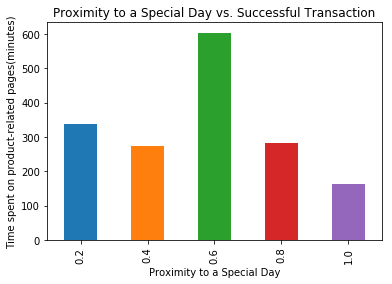

In [365]:
df_sp.ProductRelated_Duration.plot.bar()
plt.xlabel('Proximity to a Special Day')
plt.ylabel('Time spent on product-related pages(minutes)')
plt.title('Proximity to a Special Day vs. Successful Transaction')
plt.show()

Clearly, the **sweet factor** (so to speak) is 0.6. Recalling the given interpretation for Valentine's Day, this means that around February 8th, we had a maximum value for the factor, whereas in the days leading up to that, we had the sweet spot of **0.6**. So with this logic in mind, perhaps the business can focus on advertising attachments and products in bulk during this phase near a Special Day, in order to grab the most opportunities and utilize them to the max.

So, let's move on and take a look at two features that are sure to demonstrate some useful trends.

## <div id="1.5">1.5: Regional Impact & Customer types</div>

In any given business scenario, the location of the customer is a crucial factor. Binning our data across the different regions will help highlight any useful trends.

 Moreover, we all know about the value of returning customers. The key to a good retail experience for a visiting customer is for them to be greeted well by the sales representatives on the floor and to have their needs met. This ensures that they will certainly be more inclined to come back in the near future to do business once again with the company outlet.
 
 In an online scenario, the website could certainly do well if it could highlight whether it needs to improve with respect to Returning or New customers.

### Regional Analysis

First of all, how many different regions are we even dealing with in this problem?

In [366]:
len(df.Region.unique())

9

So, it appears that we have **nine unique** segments that we must consider. Let's group our data and see which regions contained the most customers who completed their visit with a transaction.

In [367]:
regional_df = df.groupby(['Region','Revenue'])[['ProductRelated']].count()
regional_df.rename(columns={'ProductRelated':'Count'},inplace=True)
regional_df

Count
Region Revenue       
1      False     4009
       True       771
2      False      948
       True       188
3      False     2054
       True       349
4      False     1007
       True       175
5      False      266
       True        52
6      False      693
       True       112
7      False      642
       True       119
8      False      378
       True        56
9      False      425
       True        86

So, the subset above clearly highlights the different groups and the number of occurences for each, but let's rather inspect the customers who actually bought something by the end of their visit.

In [368]:
reg_true = regional_df.reset_index()[regional_df.reset_index()['Revenue']==True]
reg_true.set_index('Region',inplace=True)
reg_true.sort_values('Count',ascending=False,inplace=True)
reg_true

,Revenue,Count
Region,,
1,True,771
3,True,349
2,True,188
4,True,175
7,True,119
6,True,112
9,True,86
8,True,56
5,True,52


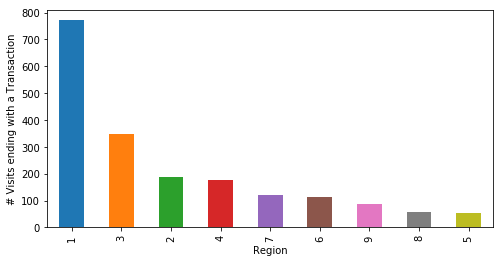

In [369]:
reg_true.Count.plot.bar(figsize=(8,4))
plt.ylabel('# Visits ending with a Transaction')
plt.xlabel('Region')
plt.show()

Clearly, customers from **Regions 1,2,3 and 4** were of high value in nature. Moving forward, the company can choose to focus their efforts on promoting services to them in order to help both parties (consumer and the business) benefit, since given the current data, we can see that these customers are rather inclined to end their visit to the website with a purchase.

### Type of customer

With regards to **the type of Customer**, let's see how many classes we're dealing with here.

In [370]:
df.VisitorType.unique()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

So, we can be dealing with either a new customer, a returning one or... **other**(which is a rather odd one).

In [371]:
visitor_df = df.groupby(['VisitorType','Revenue'])[['ProductRelated_Duration']].count().reset_index()
visitor_df.rename(columns={'ProductRelated_Duration':'Count'},inplace=True)
visitor_df.set_index('VisitorType')

,Revenue,Count
VisitorType,,
New_Visitor,False,1272
New_Visitor,True,422
Other,False,69
Other,True,16
Returning_Visitor,False,9081
Returning_Visitor,True,1470


Let's break this down. As we can see, people who are visiting the website for the first time quite often ended up buying something by the end of their visit, in comparison to those who were returning visitors to the site. In most instances of returning visitors, a huge number of them did not end up buying anything.

Over the course of the year, if we were to inspect the visitors who had a fruitful visit to the site, we would see:

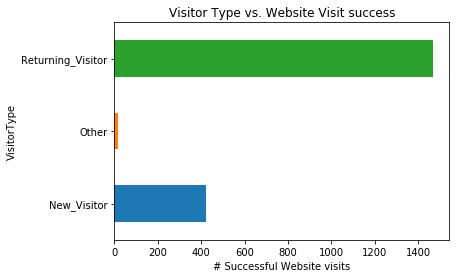

In [372]:
visitor_df = visitor_df[visitor_df['Revenue']==True]  #Only successful visits
visitor_df.set_index('VisitorType',inplace=True)
visitor_df.Count.plot.barh()
plt.xlabel('# Successful Website visits')
plt.title('Visitor Type vs. Website Visit success')
plt.show()

As expected, returning visitors account for the bulk of the data and thus we can see that they ended up sealing the deal with a transaction by the end of their visit more so than new customers.

Perhaps, the company can take some initiative to give more discount offers to first-time buyers in order to make their deals look more attractive? It would certainly help to boost those numbers into the **500+** range for the year-end tally of successful visits for new visitors to the site.

## <div id="1.6">1.6: Operating System? That's interesting...</div>

One of the features that I was quite skeptical about, was the Operating System feature. How or why would that impact our outcome?

Let's see...

In [373]:
df.OperatingSystems.unique()

array([1, 2, 4, 3, 7, 6, 8, 5], dtype=int64)

We have 8 different Operating system classes to consider. So, let's group our data accordingly to investigate the visitors who **actually purchased something**.

In [374]:
os_df = df.groupby( ['OperatingSystems','Revenue'])['Region'].count().reset_index()
os_df.rename(columns={'Region':'Count'},inplace=True)
os_true = os_df[os_df['Revenue']==True]
os_true.set_index('OperatingSystems',inplace=True)
os_true

,Revenue,Count
OperatingSystems,,
1,True,379
2,True,1155
3,True,268
4,True,85
5,True,1
6,True,2
7,True,1
8,True,17


Let's see what this actually looks like:

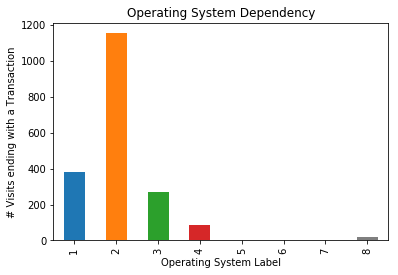

In [375]:
os_true.Count.plot.bar()
plt.ylabel('# Visits ending with a Transaction')
plt.xlabel('Operating System Label')
plt.title('Operating System Dependency')
plt.show()

Ouch. It looks like our data is heavily focused around users who were on **Operating System Class 2**.
In any event, this isn't necessarily an indication of whether a particular OS can determine the binary outcome we are trying to predict, but we must definitely keep in mind that much of our **positive outcome** class output data (ie.those who bought something) comes from the aforementioned Operating System users.

It's also worth noting that **no users** on systems **5, 6 or 7** contributed to the positive output class.

This wraps up our Exploratory Data Analysis section. We can now move on to the really exciting content:
**Data Preprocessing**

No, that isn't the exciting bit. The real action in the following section will be the **Naive Bayes classifier** that we will set up!

# <div id="sec 2">Section 2: Data Preprocessing + Vanilla model</div>

It's time to get underway with the routine checks on Data:  

<ul>
  <li>Are there any missing values?</li>
  <li>What is the **inferred type** (ie. the base type when we imported the dataset with pandas) for each of our features?</li>
  <li>Should we standardize the data?(since we will be implementing two models, the answer is by default, yes)</li>
  <li> How should we deal with the categorical features?</li>
</ul>


Before we proceed onto all the manipulations below, it's best to keep a copy of our initial DataFrame hanging around, just in case. So, we will quickly make a backup.

In [376]:
df_copy =df.copy() 

## <div id="2.1">2.1: Dealing with Categorical Features</div>

First order of business: Missing Data. I restated an important question up there that we've already answered near the beginning of this project (check <a href="#to_1.2">Section 1.2</a>). 

So, to reiterate, we do not have any null values for any of our explanatory variables, but it's always important to remind ourselves that checking for this issue is one of the first steps in data preprocessing(or **EDA** in general).

Now, let's check the **data type** that pandas inferred for each of our features when we imported the dataset.

In [377]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

It looks like all of the information related to pages(duration, count, ExitRates,etc.) have been read in as either **Integer(for whole counts)** or **Float values**. Everything looks appropriate as of yet, however two of the Categorical features that we inspected in the EDA section(**OperatingSystems  and Region **) have been assigned as integers.

In reality, they are simply distinct nominal values(relating to a particular class), so we should fix that right away. The code snippet below converts all of our prime **Categorical features** into the appropriate data type.

In [378]:
df['Month'] = pd.Categorical(df['Month'])
df['OperatingSystems'] = pd.Categorical(df['OperatingSystems'])
df['Region'] = pd.Categorical(df['Region'])
df['VisitorType'] = pd.Categorical(df['VisitorType'])

Now, it's time for us to make a judgement call in this project. From the EDA, we know that the data can indeed display some tendancy to lie towards a particular category(eg. most successful transactions were in November, users on Operating System **#2** ended up being the most active buyers).

However, intuitively speaking, it does not seem that a particular **Browser** would really impact whether a customer felt like purchasing something at the end of their session. Moreover, the analysis of the impact of different types of **Webpage Traffic types** is beyond the scope of this project. So, moving forward, to <i>slightly </i> reduce our dimensions, we will **drop** these features from our DataFrame.

In [379]:
df.drop('TrafficType',axis = 1,inplace=True)
df.drop('Browser',axis = 1,inplace=True)

Now, let's take a look at the kind of features we are working with and observe the shape of our DataFrame.

In [380]:
df.dtypes

Administrative                int64
Administrative_Duration     float64
Informational                 int64
Informational_Duration      float64
ProductRelated                int64
ProductRelated_Duration     float64
BounceRates                 float64
ExitRates                   float64
PageValues                  float64
SpecialDay                  float64
Month                      category
OperatingSystems           category
Region                     category
VisitorType                category
Weekend                        bool
Revenue                        bool
dtype: object

It's important to note that the **Weekend** feature is a Binary variable. If it's **True**(ie. a binary value of 1), the given day of the transaction was a weekend, and conversely... 

In [381]:
df.Weekend.unique()

array([False,  True], dtype=bool)

In [382]:
df.shape

(12330, 16)

We are thus dealing with **15 Explanatory Variables** and we will be using them to predict **Revenue**: will a visitor with a particular set of these features end up completing a transaction before they end their session?

We have **four categorical features**(each with their own classes) and we must now decide how to deal with those. To implement our basic classifier, we will put our machine through a bit of pain, in the sense that we will utilize **pandas** to get **Dummy variables** for each of the features.

To help alleviate some of the pain(ie. reduce some redundancy/paralellism in information) , we will drop one variable in each instance. Sounds messy? Here's a small example.

If **Month** was our only Categorical feature, we would be taking the **Month** column in our DataFrame and esssentially for each row in the dataset, if an observation had a value for Month in say 'July', we would **add a 1** under a Dummy variable column for **that month** in our new DataFrame(which will contain by default, a column for each month from our 10 categories with either a 1 or a 0 under it for each observation).

To avoid the **Dummy Variable Trap**, we will drop the column for one of the months. Why?
Well, say that an observation contains 0 under every Dummy variable column(so all **9 out of 10 initial month columns**). Within the scope of the given data, if we had initially dropped the **July Dummy variable column**, we would know inherently that the given observation was **in July**(since all other months had zero indicator variables).

An important thing to note is that by doing this, we will be **significantly increasing** our dimensions. More data does not necessarily mean better results, as we will see in a bit. However, for the purpose of getting underway with model implementations, this method of dealing with Categorical features will allow us to prepare a **Matrix of Features** on which we can run our algorithms. We can then take some steps to select the most important features.

With all that being said, let's get started.

In [383]:
df = pd.get_dummies(df, drop_first=True)   #to avoid Dummy Variable Trap

Let's look at the damage we've done:

In [384]:
df.shape

(12330, 38)

In [385]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
       'Revenue', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7',
       'OperatingSystems_8', 'Region_2', 'Region_3', 'Region_4', 'Region_5',
       'Region_6', 'Region_7', 'Region_8', 'Region_9', 'VisitorType_Other',
       'VisitorType_Returning_Visitor'],
      dtype='object')

Even after dropping one unnecessary column in each Category, we have ended up with **37 explanatory variables** that we will be plugging in by default to our model.

In [386]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


## <div id="2.2">2.2: Preparing the Matrices</div>

Since our algorithms will be leveraging matrices, it's time to say goodbye to the classic DataFrame structure we've been seing so far, because we will be seperating our data into two notable components, in **numpy** format (for the numerical computations we are about to perform):

A Matrix of **Features**(X) and a **Dependent Variable Vector**(y).

In [387]:
X = df.iloc[:,df.columns != 'Revenue'].values
y =df.iloc[:,df.columns == 'Revenue'].values

Let's take a peek at our new Matrix.

In [388]:
X

array([[0, 0.0, 0, ..., 0, 0, 1],
       [0, 0.0, 0, ..., 0, 0, 1],
       [0, 0.0, 0, ..., 1, 0, 1],
       ..., 
       [0, 0.0, 0, ..., 0, 0, 1],
       [4, 75.0, 0, ..., 0, 0, 1],
       [0, 0.0, 0, ..., 0, 0, 0]], dtype=object)

In [389]:
X.shape

(12330, 37)

So we have all of our observations, and the columns respective to each of the explanatory variables. However, in order to train our Machine Learning models on the data, we must split our data into two segments: **Training and Test Sets**.

Instead of manually doing this, we will simply utilize the **Scikit Learn **library and choose an appropriate split for our data. Let's go with  a basic **80:20** split, with **20%** of our initial data being left for testing purposes, when we will run our model on unseen data and evaluate it's performance.

In [390]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## <div id="2.3">2.3: Scaling/Standardization</div>

So, it's great that we have our necessary matrices with data, but the question is whether or not we have some **"proper"** data. Why the quotation marks?

Machine Learning Algorithms utilize several different mathematical concepts and having some unnaturally large data points throughout the data that we pass in, can have **disproportionate **impacts on the outcome. Loss functions (for Optimization purposes) are also more stable when the data is **Standardized** (ie. it has a Mean of 0, and standard deviation of 1 such that it represents the classic bell shape curve in Statistics). 

Once again, instead of reinventing the wheel, we will leverage the <i> preprocessing </i> module from the **Scikit Learn **library. Using the **StandardScaler**, we will fit a scaling object to and transform our training Matrix of features and also fit it to our Test Data. 

In [391]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [392]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

And at long last, we are ready to implement the **Gaussian Naive Bayes classifier** on our data and try and predict whether a given visitor to the website will actually buy something by the end of their browsing session.

## <div id="2.4">2.4: A very Naive classifier(pun intended) </div>


### Gaussian Naive Bayes

Before we implement the algorithm itself, let's take a look at how it actually works. The Naive Bayesian classifier works with **conditional probabilities** under the **assumption of independence**
among the explanatory feature variables. This assumption is indeed why it is called **Naive**; essentially in reality, we can see that plenty of features tend to have some inter-dependencies.

However, all things considered, the approximation is good enough to build a computationally **fast** model which can work well with **high dimensional** datasets.


In the scenario of this problem, we are dealing with a **Binary outcome class**. Say, a visitor will either purchase something(**True**) or not(**False**).
We also have some features that we have compiled in the form of a **Matrix of Features(X)**.  

So a given observation in our dataset has a certain set of probabilities associated with it. For a particular observation that we want to find the outcome label for, we can compute the following probabilities:


<u> Prior probability:</u>   $P(True)= \frac{\text{Number of observations identifying as Positive class(1908)}}{\text{Total Number of Observations(12,330)}} $

<u> Marginal Likelihood:</u>  $ P(X)= \frac{\text{Number of observations deemed to be 'similar' to our new data point}}{\text{Total Number of Observations(12,330)}}  $

<u> Likelihood:</u>  $ P(X | True)= \frac{\text{Number of observations deemed to be 'similar' to our  observation (only among POSITIVE CLASS points)}}{\text{Total Number of Observations(12,330)}} $

<u> Posterior probability:</u> $P(True | X)= \frac{\text{  P(X|True)* P(True) }}{\text{ P(X)}} $

Referring to the definitions above, we can see that our prime target is the **Posterior Probability**.
For an unseen data point, the model computes the Posterior probability above, and compares it to it's **complement** which is:





$$P(False | X)= \frac{\text{  P(X|False)* P(False) }}{\text{ P(X)}} $$

Of course, there are some other computational details that have been overlooked in the simple explanation of the algorithm above. One key component is dealing with **Zero probabilities**, which are dealt with by the sklearn library model (it applies a technique called **Laplace Smoothing** during the training process of the classifier object).

So, let's go ahead and train our **Gaussian** (assumes that continuous feature variables follow a Normal distribution) Naive Bayes classifier.

In [393]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()   #Create the classifier object

Recall from the previous section that we've already standardized the data. We can thus **fit** the classifier to our training sets.

In [394]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

And now, the moment we've been building towards since the very first line of this notebook:

In [395]:
y_pred = gnb.predict(X_test)

Tada! We have a vector of **predicted results** that our own model has inferred from unseen data.
But, is it actually worth anything?

### Confusion Matrix

In a binary classification problem such as ours, the Bayesian model labels each of the observations in our **X_test** dataset as either a **Positive class**(True) or **Negative class**(False).

As such, since we have a **y_test** vector of class labels, we can use it as a measurement of the performance of our classifier. But it isn't exactly a simple "<i>yes, our model correctly predicted that the customer would have ended his session with a transaction!"</i>  kind of scenario.

There are **four possible outcomes**:
<ul>
  <li>True Positive(**TP**)</li>
  <li>False Positive(**FP**)</li>
  <li>True Negative(**TN**)</li>
  <li>False Negative(**FN**)</li>
</ul>



Let's logically explain each case.

**True Positives** are those observations which were correctly classified as the **Positive class**(ie. the classifier correctly assigned them as being likely to end their browsing session with a purchase). The **converse** holds true for **True Negatives**(correctly identified non-buyers).

The interesting cases are **False Negatives and Positives**. False Negatives are the customers who were mistakenly classified as **not** ending their visit to the website with a purchase, whereas in reality they actually made a purchase. Similarly, the **False Positives** are those who actually didn't complete a transaction, but were assigned as the Positive class.

Two useful evaluation metrics can be computed from these measures, namely:

**Error Rate(ERR)**- $\frac{\text{FP + FN}}{\text{P+N}} $     

<i>(Best ERR~0.0)</i>

**Accuracy(ACC)**- $\frac{\text{TP+TN}}{\text{P+N}} $

<i>(Best ACC~1.0)</i>

Obviously, they are **complements** of one another, so computing one and subtracting the other one from 1 would suffice.

Utilizing sklearn, we can check out a matrix which encapsulates all of these base measures and then evaluate our classifier's performance(spoiler alert, it won't be pretty)

In [396]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))  

[[1383  661]
 [  80  342]]


In [397]:
cm=confusion_matrix(y_test, y_pred)

TP = cm[0][0]    #True Positives
FN = cm[0][1]    #False Negatives
FP = cm[1][0]    #False Positives
TN = cm[1][1]     #True Negative
total_preds = np.sum(cm)

error_rate = (FP+FN)/total_preds
accu = (TP+TN)/total_preds

So, how **accurate** was our Bayesian classifier?

In [398]:
accu

0.6995133819951338

**Almost 70% accuracy** for a model which analyzed **37 features**. It's time that we think about improving this model. In order to reduce the number of features of the data that we're feeding our model, we should pass in only the **most significant** features.How do we find out which ones we actually need?
To do so,we will now turn to one of the most powerful methods of **Dimensionality Reduction: PCA**.

# <div id="sec 3">Section 3: Dimensionality Reduction and better models</div>

## <div id="3.1">3.1: Principal Component Analysis</div>

Instead of deep diving into the inner workings of the **PCA Algorithm**, I would like to highlight the basic concept of it before applying it on our dataset. Readers who are interested in learning more about it should definitely check out this post on <a href="https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/">Analytics Vidhya</a> which certainly helped me grasp the logic behind this neat topic.

In the simplest possible definition: Principal Component Analysis allows us to take a high-dimensional dataset and reduce it to a lower dimension, without **losing significant information**.

How about a very watered-down example? On a movie set, cameras capture the scenes being shot(**real people moving and breathing in 3-Dimensions**) and allow us to eventually watch the film on the big screen(**a 2D projector of some sort**). Do we really lose any significant information in this process? Not that we care about! (credit goes to <a href="https://www.youtube.com/watch?v=_UVHneBUBW0">StatQuest</a> for the amazing explanation)

So, let's work through this process. Let's call our initial full DataFrame before we reduce it down to lower dimensions:

In [399]:
X = df.iloc[:,df.columns != 'Revenue'].values
y =df.iloc[:,df.columns == 'Revenue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

#Scale(Standardize)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Import **PCA** from the sklearn library:

In [400]:
from sklearn.decomposition import PCA

No, let's initialize our **PCA object** and apply it on our **Feature matrices**. Note that we will not specify how many features we're looking to reduce the dataset down to, as we will deal with that in a bit.

In [401]:
pca = PCA(n_components=None)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Let's check out the vector which contains the **Variance-ratio** corresponding to each feature. This array of **variance ratios** is sorted from the **feature with highest variance** to the one with **least variance**.

In [402]:
explained_variance = pca.explained_variance_ratio_
explained_variance       #Sorted Greatest-->Smallest

array([ 0.09475601,  0.05621903,  0.04972727,  0.04537941,  0.04165344,
        0.03610457,  0.03269759,  0.03126463,  0.03067678,  0.03015461,
        0.03002815,  0.02938747,  0.02925042,  0.02890536,  0.02823208,
        0.02804116,  0.02783636,  0.02769944,  0.0271654 ,  0.02682014,
        0.02670189,  0.02666183,  0.02576801,  0.02517921,  0.02491166,
        0.02309332,  0.02290786,  0.02012234,  0.01507083,  0.01160195,
        0.01145872,  0.01007551,  0.00920951,  0.00877662,  0.00330997,
        0.00199213,  0.0011593 ])

How many **key **features(in total) account for **70%** of the total variance? 

In [403]:
explained_variance[explained_variance>np.percentile(explained_variance,70)].shape

(11,)

As we can see, we can reduce our dimensions from **37 explanatory variables** down to **11 key features** which account for the most variance in the data.

So, let's do this one last time.

In [404]:
X = df.iloc[:,df.columns != 'Revenue'].values
y =df.iloc[:,df.columns == 'Revenue'].values

#re-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


#Scale(Standardize)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


#reapply PCA
pca= PCA(n_components=11)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Let's take a sneak peek at our Matrix now:

In [405]:
X_train.shape

(9864, 11)

In [406]:
X_train

array([[-0.67369994, -0.41377017, -1.59808176, ...,  0.28789717,
         0.56563199, -0.07493448],
       [ 3.1636398 ,  0.08807422,  0.65046203, ..., -0.84718621,
         0.01590689, -0.32200845],
       [ 5.17970595, -0.83865464,  1.54414103, ...,  0.6784403 ,
        -4.59072455, -0.41324397],
       ..., 
       [ 6.74807095, -1.12933725,  1.68531871, ...,  0.63577802,
         0.62927269,  0.48028339],
       [-0.45365647,  0.2308201 ,  0.33007797, ..., -0.2863945 ,
         0.68016899, -0.20365681],
       [ 0.10660604, -0.63307332, -1.16889317, ...,  0.57580462,
         0.42769723, -0.24372825]])

The values are all **standardized**, so it's not possible to interpret them as in the current state. However, we are now ready to apply the **Gaussian Naive Bayes** classifier once more.

## <div id="3.2">3.2: Naive Bayes revisited</div>


Let's create a classifier object once more, and fit it to our **reduced** matrix of features. As before, we can then proceed to evaluate the resulting **Confusion Matrix**.

In [407]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [408]:
cm =  confusion_matrix(y_test, y_pred)
cm

array([[2010,   34],
       [ 387,   35]], dtype=int64)

In [409]:
TP = cm[0][0]    #True Positives
FN = cm[0][1]    #False Negatives
FP = cm[1][0]    #False Positives
TN = cm[1][1]     #True Negative

total_preds = np.sum(cm)

error_rate = (FP+FN)/total_preds

accu = (TP+TN)/total_preds

Moment of truth...how did we do?

In [410]:
accu

0.8292781832927818

Not bad at all, we went from a model which was aproximately **70%** accurate, to one which now stands at an accuracy of nearly **83%**. Now that we've seen a Naive Bayes classifier have a run at making a prediction, let's call in another <i> star player</i>: an **Artificial Neural Network**.

## <div id="3.3">3.3: Building an Artificial Neural Network</div>

We will design the architecture of the Neural network in this section. But, let's start off by importing the **Keras library**. We will run this on the **TensorFlow** backend in order to create our **ANN classifier**.

In [411]:
import keras

We will need two other modules in order to design the structure of the model. By using the **Sequential** module from keras, we will initialize the network, and then gradually add layers one by one using the **Dense** module.

In [412]:
from keras.models import Sequential
from keras.layers import Dense

Let's initialize our (future) classifier.

In [413]:
classifier = Sequential()

It's time to add the input layer. In this problem, we are dealing with **11 explanatory features** that account for the most variance in the data. As such, the ANN we are designing will contain <i>exactly ONE</i> input layer with **11 nodes**.

The next question we can ask is about the **Output layer**. How many nodes should we have there? Since the result is simply a Binary outcome(True or False), we will have **1 node** in the Output layer. The nature of our problem is probabilistic in nature(ie. we may ask **how likely** is it that a website visitor will buy something?). It is important to note at this point that the **Activation function** that will model our final response will be a <i>**Sigmoid Function**</i> (which returns an output between 0 and 1, akin to a probability).

What about the hidden layers? For the purpose of this basic analysis, we will be adding only **two hidden layers** and they will contain a number of nodes equal to average of the input and output layers (so (11+1)/2),ie. **6 nodes**(each). 

So, let's design the input layer and the **first** hidden layer as follows:

In [414]:
classifier.add(Dense(output_dim=6, init='uniform', activation='relu',input_dim=11))

Let's quickly mention those two parameters **init** and **activation**.

Without going into a detailed explanation of the inner workings of the Artificial Neural Network (a very neat explanation can be found <a href="https://stevenmiller888.github.io/mind-how-to-build-a-neural-network/">here</a>), we need to know that in order to perform **Stochastic Gradient Descent**(SGD) to find out the optimal relevance of each of our features, we need to initialize the **weight** of each feature with a small factor (close to 0). Through repeated runs of this SGD, these weights are then readjusted. So, to get started, we utilize the **Uniform distribution** for this purpose.

We also need to specify an **Activation function** for the hidden layer, and the **Rectifier Function** (relu) will do just fine for this purpose.

Let's add our **second Hidden layer** before finishing up with our Output layer.

In [415]:
classifier.add(Dense(output_dim=6, init='uniform', activation='relu'))

Let's move on and add the **Output layer** which will give us our desired Dependent variable.

In [416]:
classifier.add(Dense(output_dim=1, init='uniform', activation='sigmoid'))

Before we compile our Neural Network, let's specify some of the optimization parameters that we will be using. 
In order for our initial weights to be updated via the Stochastic Gradient Descent algorithm, we will be utilizing the **adam** optimizer. But, what loss function are we really optimizing our results against? We will be using a **Logarithmic loss function**(with two Dependent variable classes ,hence
'binary_crossentropy').

In [417]:
classifier.compile(optimizer='adam',loss='binary_crossentropy',
                  metrics=['accuracy'])

The design of our ANN is complete and it's time for the real action: Fitting our Neural Network to the **Training set**.

In [418]:
classifier.fit(X_train,y_train, batch_size=10 , nb_epoch=100)

Epoch 1/100
9864/9864 [==============================] - 2s 170us/step - loss: 0.4202 - acc: 0.8483
Epoch 2/100
9864/9864 [==============================] - 1s 123us/step - loss: 0.3536 - acc: 0.8494
Epoch 3/100
9864/9864 [==============================] - 1s 129us/step - loss: 0.3508 - acc: 0.8494
Epoch 4/100
9864/9864 [==============================] - 1s 137us/step - loss: 0.3490 - acc: 0.8494
Epoch 5/100
9864/9864 [==============================] - 1s 129us/step - loss: 0.3475 - acc: 0.8494
Epoch 6/100
9864/9864 [==============================] - 1s 125us/step - loss: 0.3467 - acc: 0.8494
Epoch 7/100
9864/9864 [==============================] - 1s 123us/step - loss: 0.3459 - acc: 0.8494
Epoch 8/100
9864/9864 [==============================] - 1s 123us/step - loss: 0.3449 - acc: 0.8491
Epoch 9/100
9864/9864 [==============================] - 1s 122us/step - loss: 0.3448 - acc: 0.8525
Epoch 10/100
9864/9864 [==============================] - 1s 123us/step - loss: 0.3441 - acc: 0.8551

Now that we have **trained** our ANN on the appropriate set, let's compute a **vector of predictions** as in the Naive Bayes section and then inspect the **Confusion Matrix**.

In [419]:
y_pred = classifier.predict(X_test)

In [420]:
y_pred

array([[ 0.20799184],
       [ 0.11997182],
       [ 0.14411509],
       ..., 
       [ 0.46368095],
       [ 0.31928867],
       [ 0.65594244]], dtype=float32)

As we expected, for each given customer in our **Test dataset**, we have an associated probability for whether or not they will end their visit to the store with a transaction. Let's convert this to an appropriate vector of Binary values(**True if the probability is greater than 0.5, false otherwise**).

In [421]:
y_pred = y_pred>0.5
y_pred

array([[False],
       [False],
       [False],
       ..., 
       [False],
       [False],
       [ True]], dtype=bool)

Let's generate the confusion matrix and quickly inspect the relevant metrics.

In [422]:
cm =  confusion_matrix(y_test, y_pred)
cm

array([[2019,   25],
       [ 358,   64]], dtype=int64)

In [423]:
TP = cm[0][0]    #True Positives
FN = cm[0][1]    #False Negatives
FP = cm[1][0]    #False Positives
TN = cm[1][1]     #True Negative

total_preds = np.sum(cm)

error_rate = (FP+FN)/total_preds

accu = (TP+TN)/total_preds

In [424]:
accu

0.84468775344687752

Not bad at all! On our first try with our **simple** Artificial Neural Network, we have achieved an accuracy of around **84%**. This is comparable to our **Naive Bayes classifier**(~83% accuracy) and really demonstrates how useful our Principal Component Analysis section was.

# <div id="sec 4">Section 4: Conclusion</div>

## <div id="4.1">4.1: Evaluating results</div>


Let's look back at what we covered here in this notebook:

<ul>
  <li>Carried out Exploratory Data Analysis</li>
  <li>Implemented a Naive Bayes Classifier and an Artificial Neural Network</li>
  <li>Obtained accuracies of approximately **83%** and **84%** respectively</li>
</ul>




So from a practical perspective, the e-commerce site can take analytical steps such as these ones in order to get an idea of how their site visitors behave and can crunch the numbers with predictive models such as these in order to find out whether a given person with particular browsing characteristics will actually purchase something or not. This will allow them to target potential customers and help them maximize returns in the long run.

## <div id="4.2">4.2: Future improvements</div>

There are however, other **Supervised** models we could have leveraged in this problem. Future re-runs of this analysis can make use of **Support Vector Machine (SVM) classifier** or a **Decision Tree classifier** in hopes of obtaining comparable or **even better** results.

As for now, this concludes the analysis of a very interesting dataset on web-browsing behaviour.

Last but not least, thank you for reading!